In this tutorial, you will learn how to load a segment and visualize (if available), the ink labels that can be used to train an ink detection model.
### Getting Started:
First, we need to import the vesuvius package:

In [1]:
#!pip install vesuvius
#!vesuvius --accept_terms --yes;
import vesuvius
from vesuvius import Volume

Let us print the list of available segments for Scroll 1:

In [2]:
files = vesuvius.list_files()

In [3]:
for key, value in enumerate(files['1']['54']['7.91']['segments']): # the first entries are scroll_number, energy (keV), resolution (um)
    print(value)

20230503225234
20230504093154
20230504094316
20230504125349
20230504171956
20230504223647
20230504225948
20230504231922
20230505093556
20230505113642
20230505131816
20230505135219
20230505141722
20230505164332
20230505175240
20230506133355
20230507172452
20230507175928
20230508164013
20230508220213
20230509160956
20230509182749
20230510153006
20230510153843
20230510170242
20230511094040
20230511201612
20230511204029
20230511211540
20230511215040
20230511224701
20230512094635
20230512105719
20230512111225
20230512112647
20230512120728
20230512123446
20230512123540
20230512170431
20230513092954
20230513095916
20230513164153
20230514173038
20230514182829
20230515162442
20230516112444
20230516114341
20230516115453
20230517021606
20230517024455
20230517025833
20230517180019
20230517204451
20230517205601
20230518012543
20230518075340
20230518104908
20230518130337
20230518135715
20230518181521
20230518191548
20230518223227
20230519031042
20230519140147
20230519195952
20230519202000
2023051921

### Data download (change segment, the labels on this are bad)

### Wait for Julian's new segment with different chunking

We can work with segment `20230530212931`.

In [4]:
segment_id = 20230530212931
segment = Volume(segment_id, normalize=True)

As you have seen in the previous tutorial, the previous command only instantiate an object without downloading the data.
For a segment, the special method `segment.download_inklabels()` is automatically called and the ink labels, if available, are downloaded in the `self.inklabel` variable. If the ink labels are not available `segment.inklabel` will be an empty numpy array filled with 0s.

Let us visualize the layer that is supposed to be on the recto surface of the sheet of papyrus, which by convention is the number 32.

In [5]:
from matplotlib import pyplot as plt

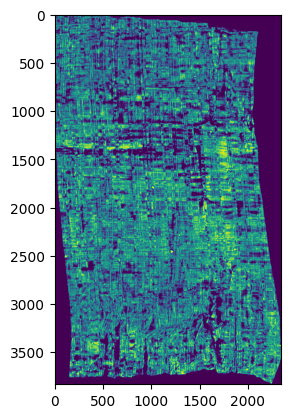

In [6]:
plt.imshow(segment[32])

This took a while! But caching is automatically activated in the `Volume` class, so the next iteration should take less time.

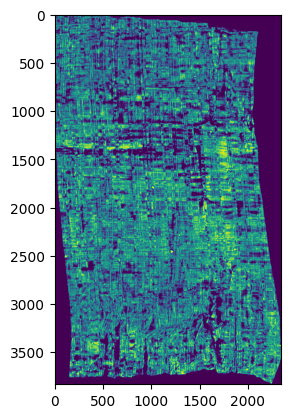

In [7]:
plt.imshow(segment[32])

We can visualize the ink labels for this segment:

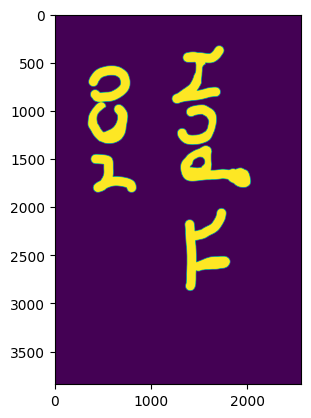

In [8]:
plt.imshow(segment.inklabel)

And the two overlayed:

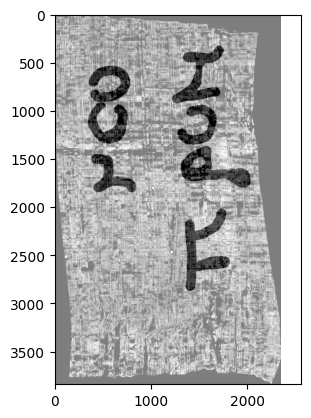

In [9]:
plt.imshow(segment[32], cmap='gray')
plt.imshow(segment.inklabel, cmap='binary', alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

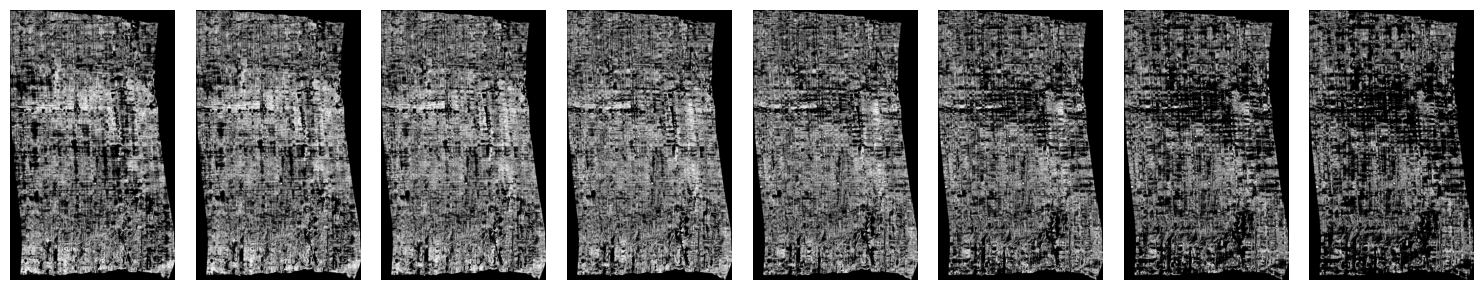

In [10]:
fig, axes = plt.subplots(1, 8, figsize=(15, 3))

# Loop through the images and the axes simultaneously
for img, ax in zip(segment[28:28+8,:,:,0], axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # This removes the ticks and labels in one go

# Adjust the layout to make sure there is no overlap
fig.tight_layout()

# Display the plot
plt.show()

## Ink Detection

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 8   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

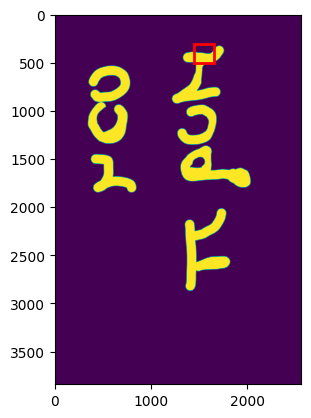

In [107]:
rect = (1450, 300, 200, 200)
fig, ax = plt.subplots()
ax.imshow(segment.inklabel)
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [119]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = torch.from_numpy(image_stack).float()
        self.label = torch.from_numpy(label.astype(np.float32)//200).float()
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y,x].view(1)
        return subvolume, inklabel

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.GELU(),
    nn.LazyLinear(1)
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss().to(DEVICE)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()

Sequential(
  (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): LazyLinear(in_features=0, out_features=128, bias=True)
  (8): GELU(approximate='none')
  (9): LazyLinear(in_features=0, out_features=1, bias=True)
)

In [120]:
print("Generating patch lists...")


# Create a 2D Boolean mask that is True where there is any signal across the Z dimension
mask = np.max(segment[:,:,:], axis=0).astype(bool)

# Create a Boolean mask to exclude border pixels (those that cannot form a full patch)
not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True

# Combine the signal mask and the not_border mask
arr_mask = mask * not_border

# Create inside_rect and outside_rect masks
inside_rect = np.zeros(mask.shape, dtype=bool)
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
inside_rect *= arr_mask  # Only include areas within the segment

outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False

# Further customization to exclude specific regions with little ink
outside_rect[2000:,:1000] = False
outside_rect[:,1800:] = False
outside_rect[:,900:1200] = False
outside_rect[:500, :] = False
outside_rect[3000:, :] = False

pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)


Generating patch lists...


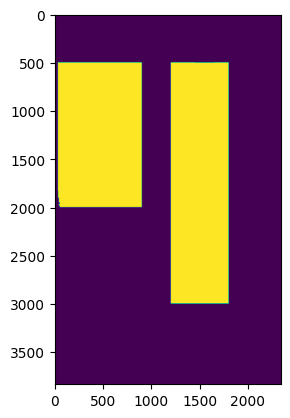

In [121]:
plt.imshow(outside_rect)

In [122]:
# Create the train and validation datasets using the generated patch coordinates
train_dataset = SubvolumeDataset(segment[Z_START:Z_START+Z_DIM,:,:], segment.inklabel, pixels_outside_rect)

# Create DataLoader objects for training and validation
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [123]:
from torch.cuda.amp import GradScaler, autocast

In [124]:
print("Training...")
running_loss = 0.0
scaler = GradScaler()
running_loss = 0.0
j= 0
scaler= GradScaler()
model.train()
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    subvolumes, inklabels = subvolumes.to(DEVICE), inklabels.to(DEVICE)
    
    with autocast():
        outputs = model(subvolumes)
        # Compute loss
        loss = criterion(outputs, inklabels)

    # Scale loss and call backward
    scaler.scale(loss).backward()
            
    # Optimizer step with scaled gradients
    scaler.step(optimizer)
        
    # Update the scaler for the next iteration
    scaler.update()
            
    scheduler.step()
    # Accumulate running loss
    running_loss += loss.item()
            
    if (i+1)%1000 == 0:
        print(f"Training Loss [{i + 1}]: {running_loss / 1000:.6f}")
        running_loss = 0.0


/tmp/ipykernel_23076/310100751.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_23076/310100751.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler= GradScaler()


Training...


  0%|          | 0/30000 [00:00<?, ?it/s]/tmp/ipykernel_23076/310100751.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1031/30000 [00:05<02:17, 210.76it/s]

Training Loss [1000]: 0.573548


  7%|▋         | 2032/30000 [00:09<02:14, 207.17it/s]

Training Loss [2000]: 0.569583


 10%|█         | 3028/30000 [00:14<02:13, 201.44it/s]

Training Loss [3000]: 0.566185


 13%|█▎        | 4040/30000 [00:19<02:02, 212.71it/s]

Training Loss [4000]: 0.558475


 17%|█▋        | 5030/30000 [00:24<01:56, 213.77it/s]

Training Loss [5000]: 0.568682


 20%|██        | 6041/30000 [00:28<01:51, 214.97it/s]

Training Loss [6000]: 0.566994


 23%|██▎       | 7031/30000 [00:33<01:46, 216.06it/s]

Training Loss [7000]: 0.569566


 27%|██▋       | 8021/30000 [00:38<01:44, 209.99it/s]

Training Loss [8000]: 0.565407


 30%|███       | 9033/30000 [00:42<01:39, 211.42it/s]

Training Loss [9000]: 0.571924


 33%|███▎      | 10022/30000 [00:47<01:34, 210.85it/s]

Training Loss [10000]: 0.570948


 37%|███▋      | 11029/30000 [00:52<01:29, 210.97it/s]

Training Loss [11000]: 0.567863


 40%|████      | 12040/30000 [00:57<01:23, 214.83it/s]

Training Loss [12000]: 0.567807


 43%|████▎     | 13027/30000 [01:01<01:20, 210.85it/s]

Training Loss [13000]: 0.573129


 47%|████▋     | 14024/30000 [01:06<01:16, 207.94it/s]

Training Loss [14000]: 0.568902


 50%|█████     | 15034/30000 [01:11<01:11, 208.57it/s]

Training Loss [15000]: 0.569059


 53%|█████▎    | 16037/30000 [01:16<01:05, 212.94it/s]

Training Loss [16000]: 0.569014


 57%|█████▋    | 17027/30000 [01:20<01:00, 214.80it/s]

Training Loss [17000]: 0.570102


 60%|██████    | 18039/30000 [01:25<00:56, 212.11it/s]

Training Loss [18000]: 0.567259


 62%|██████▏   | 18713/30000 [01:28<00:53, 211.39it/s]


KeyboardInterrupt: 

In [114]:
val_dataset = SubvolumeDataset(segment[Z_START:Z_START+Z_DIM,:,:], segment.inklabel, pixels_inside_rect)

eval_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/632 [00:00<?, ?it/s]/tmp/ipykernel_23076/517790363.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 632/632 [00:01<00:00, 329.99it/s]


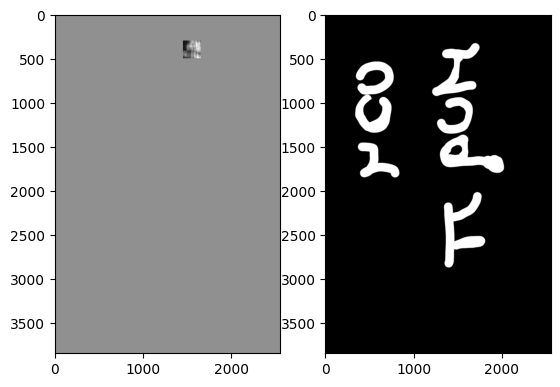

In [115]:
output = torch.zeros(segment.inklabel.shape).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(val_loader)):
        with autocast():
            for j, value in enumerate(model(subvolumes.to(DEVICE))):
                output[tuple(pixels_inside_rect[i*BATCH_SIZE+j])] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu().sigmoid(), cmap='gray')
ax2.imshow(segment.inklabel, cmap='gray')
plt.show()

  0%|          | 0/43804 [00:00<?, ?it/s]/tmp/ipykernel_23076/2318482603.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 43804/43804 [02:07<00:00, 344.84it/s]


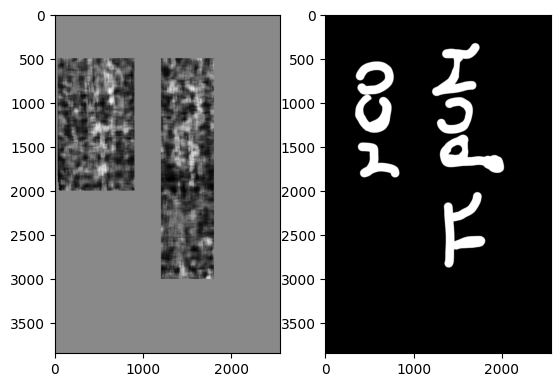

In [116]:
output = torch.zeros(segment.inklabel.shape).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        with autocast():
            for j, value in enumerate(model(subvolumes.to(DEVICE))):
                output[tuple(pixels_outside_rect[i*BATCH_SIZE+j])] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu().sigmoid(), cmap='gray')
ax2.imshow(segment.inklabel, cmap='gray')
plt.show()